In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/4-1_Semester/practice code/Time Series Forecasting/monthly_milk_production.csv', parse_dates=True)
#df.index.freq='MS' # specify that dealing with monthly data, 
df.head()

,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


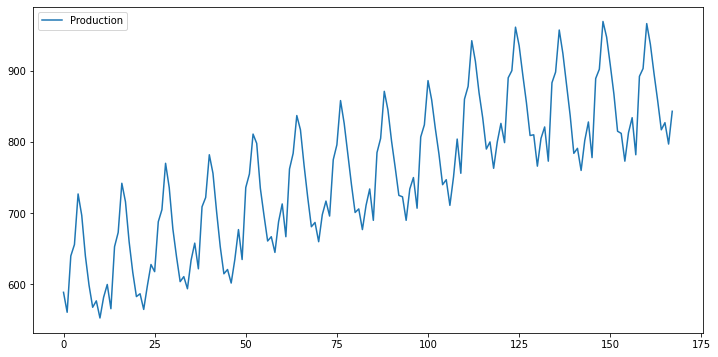

In [ ]:
#Plot the dataset
df.plot(figsize=(12,6))

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
results = seasonal_decompose(df['Production'])
results.plot()

AttributeError: ignored

In [ ]:
len(df)

168

In [ ]:
train = df.iloc[:150]
test= df.iloc[150:]

In [ ]:
#MinMaxScaler- covert dataset into scale of 0 to 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
scaler.fit(train)
scaled_train= scaler.transform(train)
scaled_test= scaler.transform(test)

ValueError: ignored

In [ ]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# define generator
n_input = 12 
n_features =1 
generator = TimeseriesGenerator(scaled_train,scaled_train, length=n_input, batch_size=1)

In [ ]:
x,y = generator[1]
print(f'Given the Array: \n{x.flatten()}')
print(f'Predict this y: \n{y}')

Given the Array: 
[0.01923077 0.20913462 0.24759615 0.41826923 0.34615385 0.20913462
 0.11057692 0.03605769 0.05769231 0.         0.06971154 0.11298077]
Predict this y: 
[[0.03125]]


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
# define models
model= Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 100)               40800     
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
model.fit(generator, epochs=70)

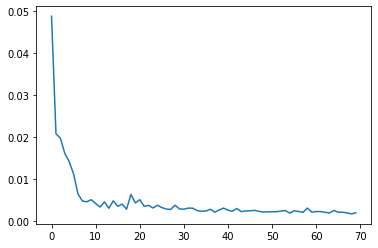

In [ ]:
loss_per_epoch= model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [ ]:
#take last 12-month value from traning set to predict for the 1st value of the test set
last_train_batch=scaled_train[-12:]

#last train batch reshape as x.shape after [42]
last_train_batch = last_train_batch.reshape((1,n_input, n_features))

In [ ]:
#predict value
model.predict(last_train_batch)

array([[0.8346223]], dtype=float32)

In [ ]:
#actual value
scaled_test[0]

array([0.85336538])

In [ ]:
test_predictions = []
first_eval_batch = scaled_train[-n_input: ]
current_batch = first_eval_batch.reshape((1,n_input, n_features))

for i in range(len(test)):

  # get prediction value for the first batch
  current_pred = model.predict(current_batch)[0]

  # append the prediction in the array
  test_predictions.append(current_pred)

  #use prediction to update the batch and remove the forst value
  current_batch = np.append(current_batch[:,1:, :], [[current_pred]], axis=1)

In [ ]:
test_predictions

[array([0.8346223], dtype=float32),
 array([0.70634764], dtype=float32),
 array([0.60246545], dtype=float32),
 array([0.57520986], dtype=float32),
 array([0.5436879], dtype=float32),
 array([0.5903951], dtype=float32),
 array([0.64716375], dtype=float32),
 array([0.6304322], dtype=float32),
 array([0.82492644], dtype=float32),
 array([0.89273596], dtype=float32),
 array([1.0015166], dtype=float32),
 array([0.9745353], dtype=float32),
 array([0.8662484], dtype=float32),
 array([0.7299415], dtype=float32),
 array([0.62579954], dtype=float32),
 array([0.58267707], dtype=float32),
 array([0.561151], dtype=float32),
 array([0.58625424], dtype=float32)]

In [ ]:
test.head()

,Production
Date,
1974-07-01,908
1974-08-01,867
1974-09-01,815
1974-10-01,812
1974-11-01,773


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


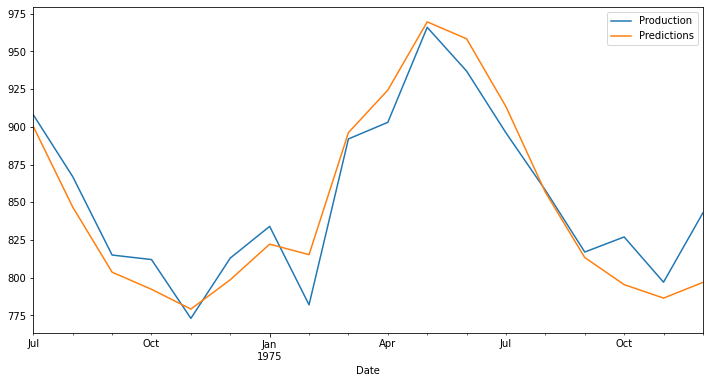

In [ ]:
# convert into  real value
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test.plot(figsize=(12,6))

In [ ]:
# calculate root mean squre error

from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(test['Production'], test['Predictions']))
print(rmse)

19.685485463767353
